In [9]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Load Data

We have a list of stock tickers and the number of RobinHood accounts holding each at fifteen minute intervals. We'd ultimately like to link some measure of the retail popularity of each ticker on each day with each comment that mentions it. Before we can do that, we need to refine what we mean by "retail popularity" and set some performance baselines.

The cells below will load the RobinHood data and save a table of the number of accounts holding each ticker on each day. 

In [5]:
# Load ticker and post data
tickers = pd.read_csv('../../data/tabular/tickers.csv')

posts = pd.read_csv('../../data/tabular/wsb_posts/cleaned posts.csv',
                    index_col=0)

posts['date'] = pd.to_datetime(posts['created_utc']).dt.date
posts = posts.drop(columns=['created_utc'])

In [7]:
# calculate the number of unique tickers present in the posts data
unique_tickers = pd.Series(list(set(','.join(posts.tickers).split(','))), name='Ticker').sort_values()
n_unique = unique_tickers.shape[0]
print('There are {} unqiue tickers mentioned in WSB comments.'.format(n_unique))

There are 3294 unqiue tickers mentioned in WSB comments.


In [14]:
# Calculate the retail popularity for each ticker on each day. This will be a 
# n x m matrix where n is number of days and m is number of accounts holding

popularity_file = '../../data/tabular/accounts_holding_table.csv'

if os.path.isfile(popularity_file):
    popularity_df = pd.read_csv(popularity_file, index_col=0)
    popularity_df.index = pd.to_datetime(popularity_df.index)
else:
    ticker = unique_tickers.iloc[0]

    def aggregate_popularity(ticker):
        rh_prefix = '../../data/tabular/popularity_export'
        ticker_df = pd.read_csv('{}/{}.csv'.format(rh_prefix, ticker), 
                                parse_dates=[0])
        ticker_df = (
            ticker_df
            .groupby(ticker_df.timestamp.rename('date').dt.date)
            .last()
            [['users_holding']]
            .rename(columns={'users_holding': ticker})
        )
        return ticker_df


    def load_popularities(tickers):
        popularity_df = aggregate_popularity(tickers.iloc[0])

        for idx, ticker in tickers[1:].iteritems():
            next_ticker   = aggregate_popularity(ticker)
            popularity_df = pd.merge(popularity_df,
                                     next_ticker,
                                     left_index=True, 
                                     right_index=True,
                                     how='left')

        return popularity_df

    popularity_df = load_popularities(unique_tickers)

    popularity_df.to_csv(popularity_file)
popularity_df.head()

,AAL,AAOI,AAP,AAPL,AAT,AAWW,AAXN,ABAX,ABB,ABBV,...,ZIV,ZIXI,ZLAB,ZNGA,ZSAN,ZTO,ZTS,ZUMZ,ZUO,ZYNE
date,,,,,,,,,,,,,,,,,,,,,
2018-05-02,3755,2711,302,150785,46,103,3164,37.0,1556,13307,...,192.0,2700,182,32425,1878,433,588,248,539,6127
2018-05-03,3775,2706,294,143747,47,109,3190,37.0,1550,13222,...,184.0,2726,181,32104,1826,430,609,251,546,6150
2018-05-04,3748,2719,289,141424,47,109,3174,36.0,1546,13214,...,183.0,2734,182,31734,1785,428,607,247,550,6140
2018-05-05,3748,2719,289,141436,47,109,3174,36.0,1546,13214,...,183.0,2734,182,31738,1785,428,607,247,550,6140
2018-05-06,3748,2719,289,141437,47,109,3174,36.0,1546,13214,...,183.0,2734,182,31749,1785,428,607,247,550,6140


### Summary of Raw Data

Let's take a look at some summary statistics and distribution plots of the raw data. We're particularly interested in the stationarity of the aggregate distribution over time. The block below shows the total number of accounts in one plot and the mean, median, and standard deviation of log-accounts holding in the plot below it. 

Note that the number of accounts steadily increases throughout 2018 and 2019 before sharply increasing at the beginning of the COVID-19 pandemic in March of 2020. This behavior is matched in the mean log plot. Also note that the median and mean of the log data are close to equal throughout, indicating that the distribution is symmetric in log-space. The result of the shapiro tests over time shows that the data is not log-normally distributed because the p-value is effectively zero. This distribution is not stationary given that both the log mean and log standard deviation drift over time.

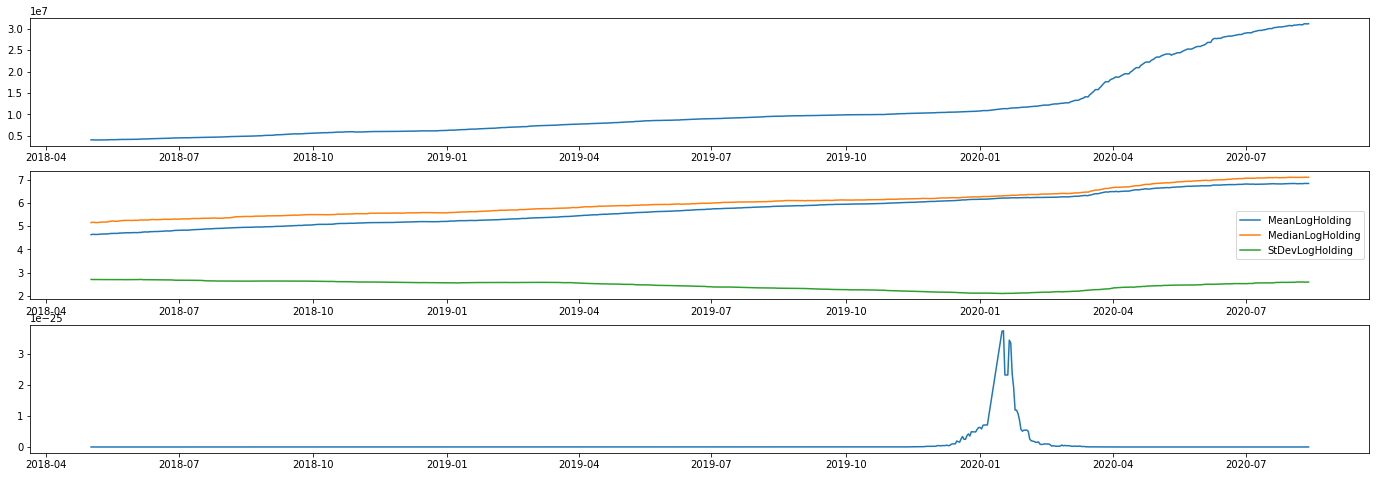

In [16]:
# Plot the log total number of accounts over time as well as the mean, median and standard 
# deviation of the number of accounts holding over time.
from scipy.stats import shapiro

log_pop_df = np.log(popularity_df.fillna(0) + 1)

aggregate_df = pd.DataFrame([
    popularity_df.sum(axis=1).rename('TotalAccts'),
    log_pop_df.mean(axis=1).rename('MeanLogHolding'),
    log_pop_df.median(axis=1).rename('MedianLogHolding'),
    log_pop_df.std(axis=1).rename('StDevLogHolding'),
    log_pop_df.apply(lambda x: shapiro(x[~x.isna()])[1], axis=1).rename('ShapiroPValue')
]).transpose()

fig, ax = plt.subplots(3, 1, figsize = (24, 8))

# plot total 
ax[0].plot(aggregate_df.index, aggregate_df['TotalAccts'])

# plot log distribution statistics
plot_cols = ['MeanLogHolding', 'MedianLogHolding', 'StDevLogHolding']
ls = [ax[1].plot(aggregate_df.index, aggregate_df[col])[0] for col in plot_cols]
ax[1].legend(ls, plot_cols)

# plot log distribution shapiro wilk test p-value
ax[2].plot(aggregate_df.index, aggregate_df['ShapiroPValue'])
plt.show()

### Rank Transformation and Binning

Rather than trying to do a regression on poorly behaved data, let's define popularity based on rank at a point in time. From there we can start with a very simple binary classification problem: is a given stock in the top decile of popularity on RobinHood? If we can predict this, then perhaps we can expand the scope of the work in the future.

In [17]:
popularity_rank_df = popularity_df.fillna(0).rank(axis=1)
decile = popularity_rank_df.quantile(0.9, axis=1)
top_decile_indicator = (popularity_rank_df > decile.values.reshape(-1, 1)).astype(int)


In [21]:
# before we proceed, we should calculate the probability on any given day that a stock transitions 
# into or out of the top ten percent. This is a discrete state markov chain.

# on average, one stock transitions into (and one out of) the top decile on a given day
transitions_per_day = (top_decile_indicator > top_decile_indicator.shift(1)).sum(axis=1)
print(f'Number of transitions per day: {transitions_per_day.mean()}')
print(f'Naive probability that a stock transitions on a given day: {transitions_per_day.mean()/3294}')

Number of transitions per day: 1.0440097799511003
Naive probability that a stock transitions on a given day: 0.0003169428597301458


A very naive benchmark for our model will be an accuracy score of 0.03%. This is a very low number to beat so we'll also evaluate our sentiment models against a logistic regression model that uses market data. Three models will be fit with lags of 3, 5, and 10 days to compare to the sentiment model lags. These models will use the trailing seven day average change in trade volume and cumulative seven-day price return.

In [49]:
returns_df = pd.read_csv('../../data/tabular/returns.csv')
volume_df = pd.read_csv('../../data/tabular/volume.csv')

returns_df['Date'] = pd.to_datetime(volume_df['Date'])
returns_df = returns_df.set_index('Date')
returns_df = np.log(returns_df + 1)
returns_df = (
    returns_df
    .rolling(7)
    .sum()
    .iloc[7:]
    .pipe(lambda x: np.exp(x) - 1)
)


volume_df['Date'] = pd.to_datetime(volume_df['Date'])
volume_df = volume_df.set_index('Date')
volume_df = (
    volume_df
    .rolling(7)
    .mean()
    .iloc[7:]
    .pipe(lambda x: np.log(1 + x))
)

lags = [3, 5, 10]
returns_dfs = {lag: (returns_df
                     .shift(lag)
                     .dropna(axis=0, how='all')
                     .dropna(axis=1, how='any')
                     .pipe(lambda x: (x - x.mean(axis=0))/x.std(axis=0)))
               for lag in lags}
volume_dfs = {lag: (volume_df
                    .shift(lag)
                    .dropna(axis=0, how='all')
                    .dropna(axis=1, how='any')
                    .pipe(lambda x: (x - x.mean(axis=0))/x.std(axis=0)))
              for lag in lags}

In [73]:
depivot_volume_dfs = {lag: (volume_df
                            .reset_index()
                            .melt(id_vars='Date',
                                  var_name='Ticker',
                                  value_name='Volume'))
                      for lag, volume_df in volume_dfs.items()}
depivot_return_dfs = {lag: (returns_df
                            .reset_index()
                            .melt(id_vars='Date',
                                  var_name='Ticker',
                                  value_name='PriceReturn'))
                      for lag, returns_df in returns_dfs.items()}

depivot_features_dfs = {lag: (pd.merge(depivot_volume_dfs[lag], 
                                       depivot_return_dfs[lag], on=['Date', 'Ticker'])
                              .pipe(lambda x: x.assign(Date = pd.to_datetime(x['Date']))))
                        for lag in depivot_volume_dfs.keys()}

In [74]:
# join transition indicator to the depivoted feature
transitions_df = (top_decile_indicator > top_decile_indicator.shift(1)).astype(int)
transitions_df = (
    transitions_df
    .reset_index()
    .melt(id_vars='date', var_name = 'Ticker', value_name = 'Transition')
    .rename(columns={'date': 'Date'})
)
transitions_df['Date'] = pd.to_datetime(transitions_df['Date'])

depivot_features_dfs = {lag: (pd.merge(depivot_features_df, transitions_df, on = ['Date', 'Ticker'])
                              .set_index(['Date', 'Ticker']))
                        for lag, depivot_features_df in depivot_features_dfs.items()}

depivot_features_dfs[3].head()

,,Volume,PriceReturn,Transition
Date,Ticker,,,
2018-05-02,AAL,-0.140829,-0.890477,0
2018-05-03,AAL,-0.126147,-0.817338,0
2018-05-04,AAL,-0.126218,-0.701374,0
2018-05-07,AAL,-0.084224,-0.930271,0
2018-05-08,AAL,-0.069620,-0.755935,0


In [75]:
assert not depivot_features_df[3].isna().any().any()
assert not depivot_features_df[5].isna().any().any()
assert not depivot_features_df[10].isna().any().any()

In [180]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

splits = {lag: train_test_split(depivot_features_df[['Volume', 'PriceReturn']],
                                depivot_features_df['Transition'],test_size=0.1)
          for lag, depivot_features_df in depivot_features_dfs.items()}



In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, roc_auc_score, recall_score

metrics = {}

for lag, split_set in splits.items():
    
    X_train, X_test, y_train, y_test = split_set
    clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)
    yh_test = clf.predict_proba(X_test)
    result_dict = {'clf': clf, 
                   'precision': precision_score(y_test, (yh_test > 0.5)[:,0]),
                   'accuracy': accuracy_score(y_test, (yh_test > 0.5)[:,0]),
                   'recall': recall_score(y_test, (yh_test > 0.5)[:,0]),
                   'roc_auc': roc_auc_score(y_test, (yh_test > 0.5)[:,0])}
    metrics[lag] = result_dict
    

# X_train = split_sets[3][0][0][['Volume', 'PriceReturn']]
# y_train = split_sets[3][0][0]['Transition']
# X_test = split_sets[3][0][1][['Volume', 'PriceReturn']]
# y_test = split_sets[3][0][1]['Transition']

# logistic_clf = LogisticRegression(random_state=0, solver = 'lbfgs').fit(X_train, y_train)
# yh_train = logistic_clf.predict_proba(X_train)
# yh_test = logistic_clf.predict_proba(X_test)

In [145]:
metrics

{3: {'clf': LogisticRegression(random_state=0),
  'precision': 0.00039910128303671734,
  'accuracy': 0.00039910128303671734,
  'recall': 1.0,
  'roc_auc': 0.5},
 5: {'clf': LogisticRegression(random_state=0),
  'precision': 0.0005395258085496363,
  'accuracy': 0.0005395258085496363,
  'recall': 1.0,
  'roc_auc': 0.5},
 10: {'clf': LogisticRegression(random_state=0),
  'precision': 0.0005025719860462366,
  'accuracy': 0.0005025719860462366,
  'recall': 1.0,
  'roc_auc': 0.5}}

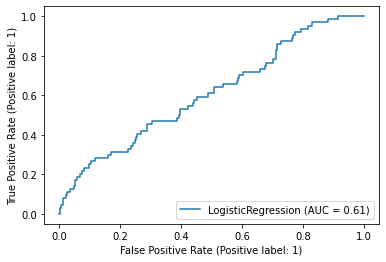

In [127]:
from sklearn import metrics

X_train = split_sets[3][0][0][['Volume', 'PriceReturn']]
y_train = split_sets[3][0][0]['Transition']
X_test = split_sets[3][0][1][['Volume', 'PriceReturn']]
y_test = split_sets[3][0][1]['Transition']

logistic_clf = LogisticRegression(random_state=0, solver = 'lbfgs').fit(X_train, y_train)
yh_train = logistic_clf.predict_proba(X_train)
yh_test = logistic_clf.predict_proba(X_test)


metrics.plot_roc_curve(logistic_clf, X_test, y_test) 

We can see that the market data classifiers are very poor but slightly better than the naive classifier. We will seek to beat these values with sentiment models.

In [192]:
n_transitions = depivot_features_dfs[3].Transition.sum()
resampled_depivot_features = {
    lag: (pd.concat(
        (split[0][split[2] == 0].sample(n_transitions),
         split[0][split[2]== 1]))
          .sample(frac=1))
    for lag, split in splits.items()}

resampled_depivot_features = {lag: (df, depivot_features_dfs[lag].loc[df.index, 'Transition'])
                              for lag, df in resampled_depivot_features.items()}
# resampled_splits = {lag: train_test_split(df[['Volume', 'PriceReturn']],
#                                           df['Transition'],test_size=0.0)
#                     for lag, df in resampled_depivot_features.items()}

In [196]:
resampled_metrics = {}

for lag, split_set in resampled_depivot_features.items():
    
    X_train, y_train = split_set
    _, X_test, _, y_test = splits[lag]
    clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)
    yh_test = clf.predict_proba(X_test)
    result_dict = {'clf': clf, 
                   'precision': precision_score(y_test, (yh_test > 0.5)[:,0]),
                   'accuracy': accuracy_score(y_test, (yh_test > 0.5)[:,0]),
                   'recall': recall_score(y_test, (yh_test > 0.5)[:,0]),
                   'roc_auc': roc_auc_score(y_test, (yh_test > 0.5)[:,0])}
    resampled_metrics[lag] = result_dict
resampled_metrics

{3: {'clf': LogisticRegression(random_state=0),
  'precision': 0.0003649450048152466,
  'accuracy': 0.27096759888842903,
  'recall': 0.5294117647058824,
  'roc_auc': 0.4001247057431627},
 5: {'clf': LogisticRegression(random_state=0),
  'precision': 0.00039893208948353637,
  'accuracy': 0.2775675515875362,
  'recall': 0.6,
  'roc_auc': 0.43870629034524067},
 10: {'clf': LogisticRegression(random_state=0),
  'precision': 0.0004042953920186173,
  'accuracy': 0.2506282149825578,
  'recall': 0.640625,
  'roc_auc': 0.4455343278615794}}

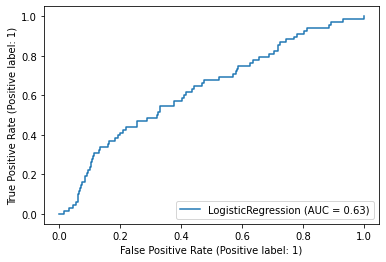

In [200]:
from sklearn.metrics import plot_roc_curve
lag = 3
plot_roc_curve(resampled_metrics[lag]['clf'], splits[lag][1], splits[lag][3]) 

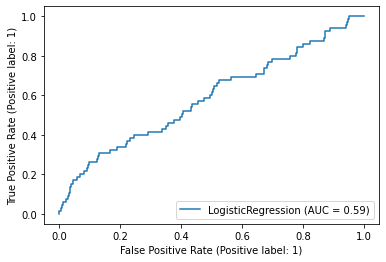

In [201]:
lag = 5
plot_roc_curve(resampled_metrics[lag]['clf'], splits[lag][1], splits[lag][3]) 

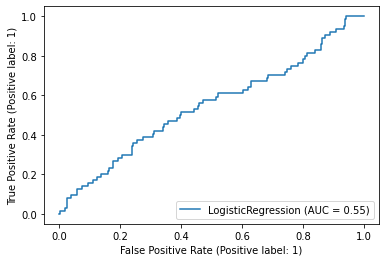

In [202]:
lag = 10
plot_roc_curve(resampled_metrics[lag]['clf'], splits[lag][1], splits[lag][3]) 